In [17]:
import pandas as pd
import numpy as np
from collections import Counter
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import IsolationForest
from sklearn import decomposition
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import warnings
warnings.filterwarnings("ignore")

In [4]:
#Importing dataset
clinical_data = pd.read_csv('clinical_data.csv')
y = clinical_data['Gleason Score']
x = pd.read_csv('gene_final.csv')
x = x.drop(columns=['ids1','ids2'])
x.rename(columns={'Unnamed: 0': 'Patient_ID'}, inplace=True)
x.set_index(['Patient_ID'], inplace=True)

In [5]:
# Fill NaN values with mean
x = x.fillna(x.mean())

Text(0.5,1,'Dataset with Outliers')

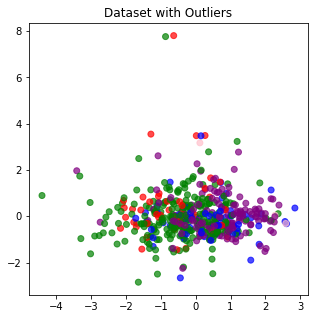

In [6]:
# Plot for dataset with outliers
pca = PCA(n_components=10)
pca_data = pca.fit_transform(x,y)

lda = LinearDiscriminantAnalysis(n_components = 2)
pca_lda_data = lda.fit_transform(pca_data,y)

label = [6,7,8,9,10]
colors = ['red','green','blue','purple','pink']

fig = plt.figure(figsize=(5,5))
plt.scatter(pca_lda_data[:,0],pca_lda_data[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors),alpha=0.7)
plt.title('Dataset with Outliers')

Text(0.5,1,'Dataset without Outliers')

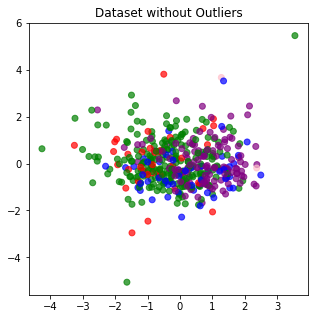

In [7]:
# Removal of Outliers and plotting
clf = IsolationForest(max_samples=100, random_state=None)
clf.fit(x)

# predictions
outliers = clf.predict(x)

outliers_series = pd.Series(outliers)
x['outliers'] = outliers_series.values
x['gleason_score'] = y.values
x_no_outliers = x[x.outliers != -1]
y_no_outliers = x_no_outliers['gleason_score']
x_no_outliers.drop(['outliers','gleason_score'],axis=1,inplace=True) 

#Dimensionality Reduction - pca
pca = PCA(n_components=10)
pca_data = pca.fit_transform(x_no_outliers,y_no_outliers)

lda = LinearDiscriminantAnalysis(n_components = 2)
pca_lda_data = lda.fit_transform(pca_data,y_no_outliers)

label = [6,7,8,9,10]
colors = ['red','green','blue','purple','pink']

fig = plt.figure(figsize=(5,5))
plt.scatter(pca_lda_data[:,0],pca_lda_data[:,1], c=y_no_outliers, cmap=matplotlib.colors.ListedColormap(colors),alpha=0.7)
plt.title('Dataset without Outliers')

In [8]:
#selecting best k-features

bestfeatures = SelectKBest(score_func=chi2, k=15000)
fit = bestfeatures.fit(x_no_outliers,y_no_outliers)
best_x = fit.transform(x_no_outliers)
best_x.shape
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))

      Features         Score
9176      9176  5.607016e+06
203        203  2.512938e+06
15742    15742  1.150962e+06
15793    15793  1.121961e+06
9175      9175  1.020109e+06
4041      4041  8.307534e+05
17949    17949  7.802146e+05
6566      6566  7.310371e+05
11420    11420  6.444844e+05
11350    11350  5.977396e+05


In [9]:
# Scaling the DataFrame
scaler = StandardScaler()
scaled_data = scaler.fit_transform(best_x)

# Eliminating low variance features
selector = VarianceThreshold()
var_thres = selector.fit_transform(scaled_data)

In [12]:
#Algos on Original Dataset

clf = SVC(gamma='auto')
scores_svm=cross_val_score(clf, x, y, scoring='accuracy', cv=10)
print("Accuracy scores for SVM-RBF algorithm on Original dataset : \n" , scores_svm , '\n')
print("Mean Accuracy :" , scores_svm.mean(),'\n')

gnb = GaussianNB()
scores=cross_val_score(gnb, x,y, scoring='accuracy', cv=10)
print("Accuracy scores for Gaussian Naive Bayes algorithm on Original dataset : \n" , scores , '\n')
print("Mean Accuracy :" , scores.mean(),'\n')

#Random Forest on Original Dataset
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1,max_depth=10,max_features='auto')
scores=cross_val_score(rf, x,y, scoring='accuracy', cv=10)
print("Accuracy scores for Random Forest algorithm on Original dataset : \n" , scores , '\n')
print("Mean Accuracy :" , scores.mean(),'\n')

#KNN neighbours on original dataset
k_scores = []
# Calculating best values for K values between 1 and 20
for i in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, x, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
    
print("Accuracy scores for K-NN algorithm on Original dataset : \n" , scores , '\n')
print(k_scores)
print("Mean Accuracy :" , scores.mean(),'\n')

Accuracy scores for SVM-RBF algorithm on Original dataset : 
 [0.48076923 0.48076923 0.48076923 0.48076923 0.5        0.51020408
 0.52083333 0.5106383  0.5106383  0.5106383 ] 

Mean Accuracy : 0.4986029231659931 

Accuracy scores for Gaussian Naive Bayes algorithm on Original dataset : 
 [0.42307692 0.55769231 0.34615385 0.42307692 0.48       0.44897959
 0.45833333 0.44680851 0.38297872 0.40425532] 

Mean Accuracy : 0.4371355478361557 

Accuracy scores for Random Forest algorithm on Original dataset : 
 [0.57692308 0.59615385 0.63461538 0.63461538 0.6        0.67346939
 0.72916667 0.63829787 0.63829787 0.65957447] 

Mean Accuracy : 0.6381113959495417 

Accuracy scores for K-NN algorithm on Original dataset : 
 [0.55769231 0.5        0.61538462 0.53846154 0.5        0.57142857
 0.54166667 0.53191489 0.55319149 0.68085106] 

[0.43759381297527195, 0.4023811472215727, 0.4822869473484975, 0.4596311193871984, 0.5163261910328779, 0.5213131979469365, 0.5334111610274224, 0.5484278366010888, 0.5

In [13]:
#Feature Selection using tree based method
clf = RandomForestClassifier(n_estimators=1)
clf = clf.fit(var_thres,y_no_outliers)

model = SelectFromModel(clf, prefit=True)
X_new_gleason = model.transform(var_thres)

In [18]:
#Resampling dataset
sme = SMOTEENN(random_state=42,smote=SMOTE(random_state=42, k_neighbors=1, m_neighbors='deprecated'))
X_res_smoteenn, y_res_smoteenn = sme.fit_resample(x_no_outliers, y_no_outliers)
print('Resampling of dataset using SMOTEENN %s' % Counter(y_res_smoteenn), '\n')

Resampling of dataset using SMOTEENN Counter({10: 227, 6: 220, 8: 208, 9: 141, 7: 35}) 



In [19]:
lda = LinearDiscriminantAnalysis(n_components = 3)
X_lda = lda.fit_transform(X_res_smoteenn,y_res_smoteenn)

In [20]:
# SVM on Resampled dataset
clf = SVC(gamma='auto')
scores_svm=cross_val_score(gnb, X_lda,y_res_smoteenn, scoring='accuracy', cv=10)
print("Accuracy scores for SVM-RBF algorithm on resampled dataset : \n" , scores , '\n')
print("Mean Accuracy :" , scores_svm.mean())

Accuracy scores for SVM-RBF algorithm on resampled dataset : 
 [0.55769231 0.5        0.61538462 0.53846154 0.5        0.57142857
 0.54166667 0.53191489 0.55319149 0.68085106] 

Mean Accuracy : 0.9951803730601849


In [21]:
#Naive Bayes on Resampled dataset
gnb = GaussianNB()
scores_nb=cross_val_score(gnb, X_lda,y_res_smoteenn, scoring='accuracy', cv=10)
print("Accuracy scores for Gaussian Naive Bayes algorithm on resampled dataset : \n" , scores , '\n')
print("Mean Accuracy :" , scores_nb.mean())

Accuracy scores for Gaussian Naive Bayes algorithm on resampled dataset : 
 [0.55769231 0.5        0.61538462 0.53846154 0.5        0.57142857
 0.54166667 0.53191489 0.55319149 0.68085106] 

Mean Accuracy : 0.9951803730601849


In [22]:
#Random Forest on Resampled dataset
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1,max_depth=10,max_features='auto')
scores_rf=cross_val_score(rf, X_lda,y_res_smoteenn, scoring='accuracy', cv=10)
print("Accuracy scores for Random Forest algorithm on resampled dataset : \n" , scores , '\n')
print("Mean Accuracy :" , scores_rf.mean())

Accuracy scores for Random Forest algorithm on resampled dataset : 
 [0.55769231 0.5        0.61538462 0.53846154 0.5        0.57142857
 0.54166667 0.53191489 0.55319149 0.68085106] 

Mean Accuracy : 0.9939604980769641


In [29]:
#KNN neighbours on resampled dataset
from sklearn.neighbors import KNeighborsClassifier

k_scores = []
# Calculating best values for K values between 1 and 20
for i in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, X_lda, y_res_smoteenn, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(scores.mean())

0.9963998852553069


Text(0,0.5,'Cross-validated accuracy')

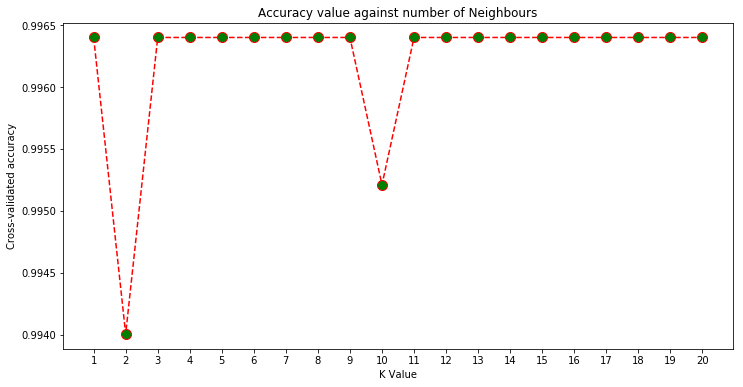

In [30]:
plt.figure(figsize=(12, 6))
x_ = [i for i in range(1,21)]
plt.plot(x_, k_scores, color='red', linestyle='dashed', marker='o',markerfacecolor='green', markersize=10)
plt.xticks(x_)
plt.title('Accuracy value against number of Neighbours')
plt.xlabel('K Value')
plt.ylabel('Cross-validated accuracy')

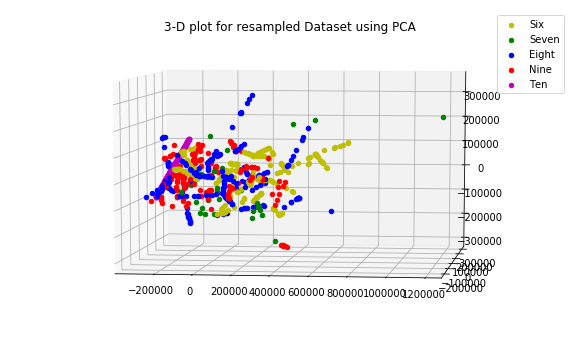

In [25]:
# PCA to visualize dataset

pca = decomposition.PCA(n_components=3)
pca.fit(X_res_smoteenn)
X_pca = pca.transform(X_res_smoteenn)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
plt.title("3-D plot for resampled Dataset using PCA")
# ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_res_smoteenn)
ax.view_init(elev=7,azim=-83)
for i in range(len(y_res_smoteenn)):
    if y_res_smoteenn[i]==6:
        six=ax.scatter(X_pca[i][0], X_pca[i][1], X_pca[i][2], c='y',label=y_res_smoteenn[i])
    elif y_res_smoteenn[i]==7:
        seven=ax.scatter(X_pca[i][0], X_pca[i][1], X_pca[i][2], c='g',label=y_res_smoteenn[i])
    elif y_res_smoteenn[i]==8:
        eight=ax.scatter(X_pca[i][0], X_pca[i][1], X_pca[i][2], c='b',label=y_res_smoteenn[i])
    elif y_res_smoteenn[i]==9:
        nine=ax.scatter(X_pca[i][0], X_pca[i][1], X_pca[i][2], c='r',label=y_res_smoteenn[i])
    elif y_res_smoteenn[i]==10:
        ten=ax.scatter(X_pca[i][0], X_pca[i][1], X_pca[i][2], c='m',label=y_res_smoteenn[i])
plt.legend((six,seven,eight,nine,ten),
           ('Six', 'Seven', 'Eight','Nine','Ten'),
           scatterpoints=1,
           loc='upper right',
           ncol=1,
           fontsize=10)

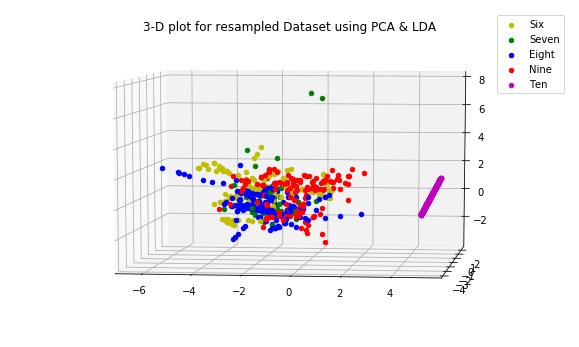

In [26]:
# PCA + LDA to visualize dataset

pca = decomposition.PCA(n_components=10)
pca.fit(X_res_smoteenn)
X_pca = pca.transform(X_res_smoteenn)
lda = LinearDiscriminantAnalysis(n_components = 3)
X_pca = lda.fit_transform(X_pca,y_res_smoteenn)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
plt.title("3-D plot for resampled Dataset using PCA & LDA")
# ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_res_smoteenn)
ax.view_init(elev=7,azim=-83)
for i in range(len(y_res_smoteenn)):
    if y_res_smoteenn[i]==6:
        six=ax.scatter(X_pca[i][0], X_pca[i][1], X_pca[i][2], c='y',label=y_res_smoteenn[i])
    elif y_res_smoteenn[i]==7:
        seven=ax.scatter(X_pca[i][0], X_pca[i][1], X_pca[i][2], c='g',label=y_res_smoteenn[i])
    elif y_res_smoteenn[i]==8:
        eight=ax.scatter(X_pca[i][0], X_pca[i][1], X_pca[i][2], c='b',label=y_res_smoteenn[i])
    elif y_res_smoteenn[i]==9:
        nine=ax.scatter(X_pca[i][0], X_pca[i][1], X_pca[i][2], c='r',label=y_res_smoteenn[i])
    elif y_res_smoteenn[i]==10:
        ten=ax.scatter(X_pca[i][0], X_pca[i][1], X_pca[i][2], c='m',label=y_res_smoteenn[i])
plt.legend((six,seven,eight,nine,ten),
           ('Six', 'Seven', 'Eight','Nine','Ten'),
           scatterpoints=1,
           loc='upper right',
           ncol=1,
           fontsize=10)